# 神经网络进行分类

本节内容是根据文本的词袋模型（什么是词袋模型？）来进行建模，然后利用神经网络来对文本进行分类。


In [3]:
!pip install jieba

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
# 导入程序所需要的程序包

#抓取网页内容用的程序包
import json
import requests

#PyTorch用的包
import torch
import torch.nn as nn
import torch.optim
#from torch.autograd import Variable

# 自然语言处理相关的包
import re #正则表达式的包
import jieba #结巴分词包
from collections import Counter #搜集器，可以让统计词频更简单

#绘图、计算用的程序包
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## 1. 神经网络分类器

首先需要学习神经网络进行分类的一般方法

从例子出发，假设我们有一个关于病人基本信息及其是否患有恶性肿瘤的数据库，如下


<img src="disease.jpg" alt="病人信息数据库" width=500 style=display:inline-block>

表中给出了若干病人年龄、肿瘤尺寸以及是否是恶性的诊断数据，这些数据可以用来预测一个新病人的肿瘤是否为恶性。

在这个例子中，年龄和肿瘤尺寸都是特征变量，而是否为恶性肿瘤是我们关注的目标变量，这种目标变量只在0和1之间取值，这种数据也叫做标签。

神经网络要学习的是从特征变量到目标变量之间的映射。

### 1.1 如何利用神经网络进行分类

像处理预测问题一样，搭建人工神经网络进行分类。 其中输入神经元对应特征变量的数量，输出神经元的数量一般要和目标类别数一致。 比如，在肿瘤预测中，我们要将结果分为两类的话，输出神经元的个数就是2。


与预测神经网络的输出层不同，分类神经网络的输出层虽然也是一个实数，但它的取值范围是（0,1）区间中的一个实数，而且要求输出单元的所有输出值之和为1。我们要从所有的输出中选择一个数值最大的进行输出，它所对应的神经元编号就是神经网络给出的最后类别。

因为输出是互斥的，所以相当于输出的是概率最大的那个结果。


<div style="text-align:center"><img src="pic1.jpg" alt="基础分类" width=500 style=display:inline-block>

比如，针对上面的肿瘤分类问题，我们可以构造一个包含2个输入单元、3个隐含单元、2个输出单元的神经网。上面就是最终结果之和为1，恶性概率0.8大于良性0.2，所以最终的判断就是0，即“恶性”。

之前使用了sigmoid函数（可以输出0-1之间），但是不能保证输出的两个神经元数值之和为1。所以这时要选择常用的softmax函数（归一化指数函数），

它的表达式为：$$\mathbf{\frac{e^{x_i}}{\sum_{i=1}^{n} e^{x_i}}}$$

假如输出单元的输入是 x = [[$x_1$,$x_2$]],那么通过如下可以完成softmax函数
]


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

下面实现softmax函数

In [4]:
x1 = np.linspace(-10, 10, 100)
x2 = np.zeros_like(x1) 
x = torch.tensor([x1, x2], dtype=torch.float32).T  #为什么这里要转置？？

C:\Users\qnmdgpqs\AppData\Local\Temp\ipykernel_14344\2885783118.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  x = torch.tensor([x1, x2], dtype=torch.float32).T  #为什么这里要转置？？


在PyTorch中，torch.nn.functional.softmax 函数的 dim 参数表示要在哪个维度上计算 softmax。在这个例子中，我们有一个大小为 (100, 2) 的张量 x，其中 100 表示样本数，2 表示每个样本有两个特征。我们希望对每个样本的特征维度进行 softmax 操作，因此我们选择 dim=1。

然而，torch.nn.functional.softmax 函数默认操作的是最后一个维度，因此我们需要确保特征维度是最后一个维度。因此，我们在创建 x 时使用了 .T（转置），将原先的 (2, 100) 转置成 (100, 2)。

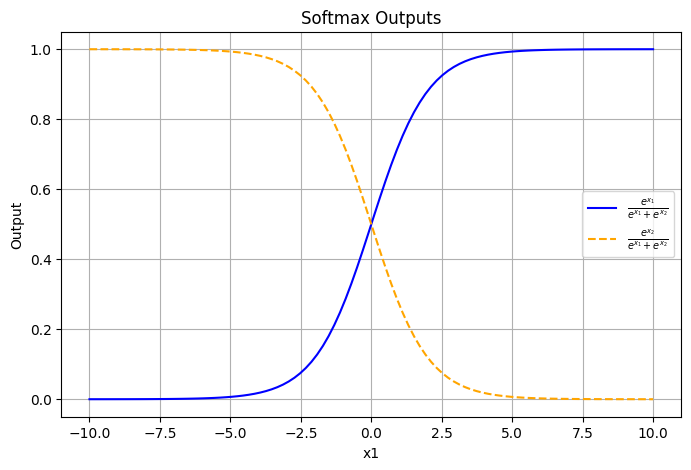

In [5]:
y = torch.nn.functional.softmax(x, dim=1)
#y 是经过 softmax 操作后的输出，y[:, 0] 表示对每个样本的第一个特征进行 softmax 操作的结果
#y[:, 1] 表示对每个样本的第二个特征进行 softmax 操作的结果。


plt.figure(figsize=(8, 5))

plt.plot(x1, y[:, 0].numpy(), label=r'$\frac{e^{x_1}}{e^{x_1}+e^{x_2}}$', linestyle='-', color='blue')

plt.plot(x1, y[:, 1].numpy(), label=r'$\frac{e^{x_2}}{e^{x_1}+e^{x_2}}$', linestyle='--', color='orange')

plt.title('Softmax Outputs')
plt.xlabel('x1')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

当输出单元为2个的时候，softmax函数式两条曲线。横坐标为$x_1$,纵坐标为$y_1,y_2$,分别表示第一个和第二个神经元的输出值。

其中$x_1$是从[-10,10]中取值，$x_2$始终等于0

softmax函数和sigmoid函数都能起到非线性映射的作用。同时，由于softmax函数包含了指数函数exp，所以它的输出必然大于0；又因为softmax函数的每一项都要除以一个归一化因子，所以这个形式自然保证了输出值之和必然为1。

接下来，可以按照输出值最大元素来做分类预测，使用以下语句可以完成：

<center><strong>y = torch.nn.functional.softmax(x,dim=1)</strong></center>  

<br>
<center><strong>c = torch.max(y, 0)[1] # c 的值将是一个包含每个样本最大概率的类别索引的张量</strong></center>




举个例子：

                            # 假设 y 是一个包含类别概率分布的张量
                        y = torch.tensor([[0.2, 0.5, 0.3],
                                          [0.7, 0.1, 0.2],
                                          [0.3, 0.2, 0.5]])
                        
                        # 从每个样本的类别分布中抽取一个样本
                        c = torch.multinomial(y, 1)
                        结果就是  tensor([1, 0, 2])

)


torch.max(y, 0) 返回的是一个包含两个张量的元组 (最大值, 最大值的索引) 所以这样就可以返回对应的索引了

因为结果之和为1，跟概率的解释一致，所以我们也可以根据概率来分类


<center><strong>y = torch.nn.functional.softmax(x,dim=1)</strong></center>

<br>
<center><strong>c = torch.multinomial(y,1) # 从每个样本的类别分布中抽取一个样本</strong></center>

举个例子：

                        
                        # 假设 y 是一个包含类别概率分布的张量
                        y = torch.tensor([[0.2, 0.5, 0.3],
                                          [0.7, 0.1, 0.2],
                                          [0.3, 0.2, 0.5]])
                        
                        # 从每个样本的类别分布中抽取一个样本
                        c = torch.multinomial(y, 1)
                        
                        print(c)
                        tensor([[1],
                                [0],
                                [2]])

                                


torch.multinomial(y,1)的作用是以为概率输出类别编号，而且，对于同样的，每次运行得到的都不一样。因此，multinomial的作用就相当于一次依概率分布的采样，第二个参数1表示我们需要的采样个数为1。


### 1.2 分类问题的损失函数

前面是分类神经网络的前馈运算过程，接下来看看它的反馈运算过程，也就是如何对分类网路进行训练。

对于分类问题，通常采用交叉熵的损失函数：$$\mathbf{L={\sum_{i=1}^{N} log y_{c_i}}}$$



这里的求和是对所有的训练样本进行的，N为训练样本数量。如果是分批训练的，那么N就是批的大小，求和号中的每一项就是样本i的损失值，$c_i$就是样本i的类别标签。所以，如果训练数据i的分类为恶性肿瘤，那么$c_i$就等于0，$y_{c_i}$就是神经网络第$c_i$个输出单元的输出值。

假设我们有一个二分类问题，任务是判断一张图片中是否包含猫。我们的神经网络有一个输出单元，输出的值表示图片中包含猫的概率。这个值可以看作是模型对“包含猫”类别的置信度。

让我们考虑两个样本：

样本1（真实标签为1，即包含猫）：

模型的输出：0.8（即80%的置信度）
交叉熵损失：
−
log
⁡
(
0.8
)
≈
0.22
−log(0.8)≈0.22
样本2（真实标签为0，即不包含猫）：

模型的输出：0.2（即20%的置信度）
交叉熵损失：
−
log
⁡
(
1
−
0.2
)
≈
0.22
−log(1−0.2)≈0.22
在这个例子中，我们可以看到：

对于包含猫的样本，模型输出越大，交叉熵损失越小。
对于不包含猫的样本，模型输出越小，交叉熵损失越小。
这符合我们的直觉：模型的输出与真实标签越一致，损失越小。同时，交叉熵损失对于模型在错误类别上的预测进行了惩罚，使得模型更倾向于产生正确的输出。

在PyTorch中，只需输入：
<center><strong>func = torch.nn.LogSoftmax(dim=1)</strong></center>

<center><strong>y = func(x)</strong></center>

<center><strong>L = torch.nn.NLLLoss()</strong></center>

<center><strong>loss = L(y,z)</strong></center>


这样可以计算出在预测输出$y$和目标标签$z$上的损失函数值了，它被存储在loss中。接下来，只需要调用调用loss.backward()就可以完成反向传播算法的计算。

这里的$x$是一个尺寸为$(N,c)$的张量，它是softmax层的输入，$N$为批的大小，$c$为类别总数；

$y$也是尺寸为$(N,c)$的张量，是softmax层的输出；$z$为目标变量的数据,它是一个长度为$N$的一维张量（向量）；而loss是一个数（标量），即这批样本的损失函数值。



<br>

<strong>
相比预测问题而言，分类问题有如下特点：
·输出单元数为类别数；

·每个输出单元的输出值为一个(0, 1)区间中的数，而且它们加起来等于1；

·最后一层计算为softmax函数；

·最终的输出类别为使得输出值最大的类别，或者根据输出值概率大小随机选取输出类别；

·采用了交叉熵这个特殊的损失函数形式。
</strong>

## 2. 词袋模型分类器

了解了使用人工神经网路解决分类问题的基本原理和方法，可以看看如何解决情绪分类器的问题。 但最大的问题是：<strong>输入的文本为不等长的符号序列，而神经网络的输入层通常具有固定的单元数，应该如何把不等长的文本输入到神经网络中呢？</strong>

这个问题等价于如何将一个不等长的符号序列向量。一个比较容易想到的方法是利用独热编码的方式将每一个字或词都进行向量化，然后再把所有字或词的向量拼接起来输入神经网络。同时，为了能够应付所有的句子，我们可以用最长句子的长度与字或词编码长度的乘积作为输入神经元的数量。但这样需要存储字或词的空间以及调用的空间会浪费很多。需要别的解决办法。

### 2.1 词袋模型简介

词袋（bag of words）模型是一种简单而有效的对文本进行向量化表示的方法。简单来说，词袋模型就是将一句话中的所有单词都放进一个袋子（单词表）里，而忽略语法、语义，甚至单词之间的顺序等信息。只关心每一个单词的数量，然后根据数量建立对句子进行表征的向量。

本质上就是提取不同词的数量个数，以向量形式存储，可以进行归一化从而让神经网路的训练更快，因为数字的范围是统一的。

### 2.2 搭建简单文本分类器

我们的素材是从该书GitHub页面的04_data中下载，接下来对数据进行预处理（去除标点符号、分词），从而构建出相关的单词表；然后通过上述方法将每一条评价都向量化为对应维数的向量。

构建的仍是3层的神经网络，第一层是对应的输入节点，第二层是中间节点，最后一层是由两个节点的输出构成，这可以帮助我们判断评价中的情绪。

如果一句话中出现大量正面意义的词，那么这句话包含的情绪总体上是正面的，反之亦然。

## 3. 程序实现

数据包括两部分，一部分是评论本身，另一部分是对这个评论所打的标签，当用户的评价超过三星的时候，我们就标记这条评论为正，否则为负<strong>{（这个过程怎么实现？）</strong>。

In [6]:
# # 在指定的url处获得评论
# def get_comments(url):
#     comments = []
#     # 打开指定页面
#     resp = requests.get(url)
#     resp.encoding = 'gbk'
    
#     #如果200秒没有打开则失败
#     if resp.status_code != 200:
#         return []
    
#     #获得内容
#     content = resp.text
#     if content:
#         #获得（）括号中的内容
#         ind = content.find('(')
#         s1 = content[ind+1:-2]
#         try:
#             #尝试利用jason接口来读取内容，并做jason的解析
#             js = json.loads(s1)
#             #提取出comments字段的内容
#             comment_infos = js['comments']
#         except:
#             print('error')
#             return([])
        
#         #对每一条评论进行内容部分的抽取
#         for comment_info in comment_infos:
#             comment_content = comment_info['content']
#             str1 = comment_content + '\n'
#             comments.append(str1)
#     return comments

# good_comments = []

# #评论抓取的来源地址，其中参数包括：
# #productId为商品的id，score为评分，page为对应的评论翻页的页码，pageSize为总页数
# #这里，我们设定score＝3表示好的评分。
# good_comment_url_templates = [
#     'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv8914&productId=10359162198&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
#     'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv73&productId=10968941641&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
#     'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv4653&productId=10335204102&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
#     'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv1&productId=1269194114&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
#     'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv2777&productId=1409704820&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
#     'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv174&productId=10103790891&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
#     'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv9447&productId=1708318938&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
#     'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv111&productId=10849803616&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0'
# ]

# # 对上述网址进行循环，并模拟翻页100次
# j=0
# for good_comment_url_template in good_comment_url_templates:
#     for i in range(100):
#         url = good_comment_url_template.format(i)
#         good_comments += get_comments(url)
#         print('第{}条纪录，总文本长度{}'.format(j, len(good_comments)))
#         j += 1
# #将结果存储到good.txt文件中
# fw = open('data/good.txt', 'w')
# fw.writelines(good_comments)

In [7]:
# # 负向评论如法炮制
# bad_comments = []
# bad_comment_url_templates = [
#     'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv8914&productId=10359162198&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
#     'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv73&productId=10968941641&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
#     'http://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv4653&productId=10335204102&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
#     'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv1&productId=1269194114&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
#     'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv2777&productId=1409704820&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
#     'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv174&productId=10103790891&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
#     'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv9447&productId=1708318938&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
#     'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv111&productId=10849803616&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0'
# ]

# j = 0
# for bad_comment_url_template in bad_comment_url_templates:
#     for i in range(100):
#         url = bad_comment_url_template.format(i)
#         bad_comments += get_comments(url)
#         print('第{}条纪录，总文本长度{}'.format(j, len(bad_comments)))
#         j += 1

# fw = open('data/bad.txt', 'w')
# fw.writelines(bad_comments)

该语料数据可以从本书GitHub页面的04_Text_classification文件夹中下载，正面评价数据存储在data/good.txt文件中，负面评价数据存储在data/bad.txt文件中。

<strong>程序的实现主要包括数据处理、文本数据向量化、划分数据集和建立神经网络四个步骤。</strong>

### 3.1 数据处理

获得原始数据后，可以对数据进行预处理，包括三个步骤：过滤标点符号、分词和建立单词表。

过滤标点符号的操作我们通过filter_punc()函数完成，它通过调用正则表达式的相应程序包，替换了所有中英文的标点符号。
然后，通过调用“结巴”分词包来对原始文本进行分词。我们只需要调用jieba.lcut(x)就可以将x中的字符分成若干个单词，并存储在一个列表中。
最后，通过调用Python的字典(diction)来建立单词表，其中字典中存储了每个单词作为键(key)，一对数字分别表示单词的编号以及单词在整个语料中出现的次数。存储第一个数值的目的是用数字来替换文字，存储第二个数值的目的是方便查看不同单词出现的频率。代码如下：


In [8]:
# 数据来源文件
good_file = 'data/good.txt'
bad_file  = 'data/bad.txt'

# 将文本中的标点符号过滤掉
def filter_punc(sentence):
    sentence = re.sub("[\s+\.\!\/_,$%^*(+\"\'“”《》?“]+|[+——！，。？、~@#￥%……&*（）：]+", "", sentence)
    return(sentence)

# 扫描所有的文本，分词并建立词典，分出正面还是负面的评论，is_filter可以过滤标点符号
def Prepare_data(good_file, bad_file, is_filter = True):
    all_words = [] # 存储所有的单词
    pos_sentences = [] # 存储正面评论
    neg_sentences = [] # 存储负面评论
    with open(good_file, 'r', encoding='utf-8') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                # 过滤标点符号
                line = filter_punc(line)
            # 分词
            words = jieba.lcut(line)
            if len(words) > 0:
                all_words += words
                pos_sentences.append(words)
    print('{0} 包含 {1} 行，{2} 个单词.'.format(good_file, idx+1, len(all_words)))

    count = len(all_words)
    with open(bad_file, 'r', encoding='utf-8') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                line = filter_punc(line)
                words = jieba.lcut(line)
            if len(words) > 0:
                all_words += words
                neg_sentences.append(words)
    print('{0} 包含 {1} 行，{2} 个单词.'.format(bad_file, idx+1, len(all_words)-count))

    # 建立词典，diction的每一项为{w:[id, 单词出现次数]}
    diction = {}
    cnt = Counter(all_words)
    for word, freq in cnt.items():
        diction[word] = [len(diction), freq]
    print('字典大小：{}'.format(len(diction)))
    return(pos_sentences, neg_sentences, diction)

#根据单词返还单词的编码
def word2index(word, diction):
    if word in diction:
        value = diction[word][0]
    else:
        value = -1
    return(value)

#根据编码获得单词
def index2word(index, diction):
    for w,v in diction.items():
        if v[0] == index:
            return(w)
    return(None)

pos_sentences, neg_sentences, diction = Prepare_data(good_file, bad_file, True)
st = sorted([(v[1], w) for w, v in diction.items()])
#st

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\qnmdgpqs\AppData\Local\Temp\jieba.cache
Loading model cost 0.639 seconds.
Prefix dict has been built successfully.


data/good.txt 包含 8089 行，100839 个单词.
data/bad.txt 包含 5076 行，56070 个单词.
字典大小：7135


### 3.2 文本数据向量化

现在我们已经获取到了京东的评论数据，并且将评论分为了正样本和负样本，接下来就使用词袋模型将文本数据向量化。我们会通过一个函数sentence2vec()来实现。
接下来，我们遍历所有的评论，将其转化为词袋向量。然后，将所有数据分成训练集、校验集和测试集。代码如

In [9]:
# 输入一个句子和相应的词典，得到这个句子的向量化表示
# 向量的尺寸为词典中词汇的个数，i位置上面的数值为第i个单词在sentence中出现的频率
def sentence2vec(sentence, dictionary):
    vector = np.zeros(len(dictionary))
    for l in sentence:
        vector[l] += 1
    return(1.0 * vector / len(sentence))

# 遍历所有句子，将每一个词映射成编码
dataset = [] #数据集
labels = [] #标签
sentences = [] #原始句子，调试用
# 处理正向评论
for sentence in pos_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(sentence2vec(new_sentence, diction))
    labels.append(0) #正标签为0
    sentences.append(sentence)

# 处理负向评论
for sentence in neg_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(sentence2vec(new_sentence, diction))
    labels.append(1) #负标签为1
    sentences.append(sentence)

#打乱所有的数据顺序，形成数据集
# indices为所有数据下标的一个全排列
indices = np.random.permutation(len(dataset))

#重新根据打乱的下标生成数据集dataset，标签集labels，以及对应的原始句子sentences
dataset = [dataset[i] for i in indices]
labels = [labels[i] for i in indices]
sentences = [sentences[i] for i in indices]

### 3.3 划分数据集

这里我们定义了3种数据集——训练集、校验集（validation或develop）和测试集，如图4.5所示。其中训练集占大多数，校验集和测试集占比较少。通常情况下，这3种数据集的大小比例大概是10∶1∶1。

<div style="text-align:center">
    <img src="pic2.jpg" alt=校验集类" width="500" style="display:inline-block">
</di>


为什么要多出一个校验集呢？这是为了检验模型是否会产生过拟合现象。过拟合现象在神经网络中体现为网络可以很好地拟合训练集数据，却无法泛化到测试集。

于是，我们需要减少模型的超参数或者提高数据量，从而提升模型的泛化能力。那么，怎么知道模型调整到什么时候为止呢？这就需要用到校验集了。首先，在训练模型的时候，是不使用校验集的。其次，在一组超参数下，当我们训练好模型之后，可以利用校验集的数据来测试模型的表现，如果误差与训练数据同样低或差不多，就说明模型的泛化能力很强，否则就说明出现了过拟合的现象

<div style="text-align:center">
    <img src="pic3.jpg" alt="未过拟合与过拟合情况的判断" width="500" style="display:inline-block">
</div>>


在每一个训练周期，我们都对训练集和测试集计算损失函数值或者错误率，并绘制上图所示的曲线。当校验集的损失或误差曲线明显高于训练集曲线，甚至还在上升的时候，就说明当前的模型已经过拟合了。我们可以通过改变超参数、增加dropout层（后面会介绍）或者增加训练数据等方式来避免过拟合。

用于调整网络的超参数，比如网络结构、学习率等，测试集用于测试模型的能力。相应地，如果训练错误率较高，说明发生了欠拟合，我们就得使用更大的模型；如果校验错误率较高，我们就得使用一系列防止过拟合的手段来调整模型超参数。总之，需要根据不同的情况动态调整。

In [10]:
#对整个数据集进行划分，分为：训练集、校准集和测试集，其中校准和测试集合的长度都是整个数据集的10分之一
test_size = len(dataset) // 10
train_data = dataset[2 * test_size :]
train_label = labels[2 * test_size :]

valid_data = dataset[: test_size]
valid_label = labels[: test_size]

test_data = dataset[test_size : 2 * test_size]
test_label = labels[test_size : 2 * test_size]

### 3.4 建立神经网络

前面我们将文本数据进行了向量化，并且对数据集进行了划分。现在终于可以开始搭建神经网络了。它包括一个输入层（7135个单元）、一个隐含层（10个单元），以及一个输出层（2个单元），代码如下所示：

In [11]:
# 一个简单的前馈神经网络，三层，第一层线性层，加一个非线性ReLU，第二层线性层，中间有10个隐含层神经元

# 输入维度为词典的大小：每一段评论的词袋模型
model = nn.Sequential(
    nn.Linear(len(diction), 10),
    nn.ReLU(),
    nn.Linear(10, 2),
    nn.LogSoftmax(dim=1),
)

接下来，我们定义一个计算分类准确率的函数。输入模型预测张量和正确的标签张量，输出模型判断正确的次数和标签张量中的数据量：

In [12]:
# 自定义的计算一组数据分类准确率的函数
# predictions为模型给出的预测结果，labels为数据中的标签。比较二者以确定整个神经网络当前的表现
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

这里，我们仍然利用PyTorch自带的Sequential命令来建立多层前馈神经网络。其中，Sequential中的每一个部件都是PyTorch的nn.Module模块继承而来的对象。
值得注意的是，这里的激活函数用的是ReLU函数。它的函数图像和表达式如下图所示。

<div style="text-align:center">
    <img src="pic4.jpg" alt="ReLU激活函数" width="500" style="display:inline-block">
</div>

可以看到，这个函数在输入大于0的时候完全是一个恒等函数，相当于没有完成任何计算，因此，与传统的sigmoid函数相比，它具有计算快、方便反向误差传播等优良特征。

同时，由于它在0的位置分成了两个不连续的部分，因此它具备与sigmoid函数同样的非线性特征。该函数特别适合用在深度的前馈神经网络中，计算效果远超sigmoid函数。

In [17]:
# 损失函数为交叉熵
cost = torch.nn.NLLLoss()
# 优化算法为Adam，可以自动调节学习率
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
records = []

#循环10个Epoch
losses = []
for epoch in range(10):
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        
        # 需要将输入的数据进行适当的变形，主要是要多出一个batch_size的维度，也即第一个为1的维度
        x = torch.tensor(x, requires_grad = True, dtype = torch.float).view(1,-1)
        # x的尺寸：batch_size=1, len_dictionary
        # 标签也要加一层外衣以变成1*1的张量
        y = torch.tensor(np.array([y]), dtype = torch.long)
        # y的尺寸：batch_size=1, 1
        
        # 清空梯度
        optimizer.zero_grad()
        # 模型预测
        predict = model(x)
        # 计算损失函数
        loss = cost(predict, y)
        # 将损失函数数值加入到列表中
        losses.append(loss.data.numpy())
        # 开始进行梯度反传
        loss.backward()
        # 开始对参数进行一步优化
        optimizer.step()
        
        # 每隔3000步，跑一下校验数据集的数据，输出临时结果
        if i % 3000 == 0:
            val_losses = []
            rights = []
            # 在所有校验数据集上实验
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = torch.tensor(x, requires_grad = True, dtype = torch.float).view(1,-1)
                y = torch.tensor(np.array([y]), dtype = torch.long)
                predict = model(x)
                # 调用rightness函数计算准确度
                right = rightness(predict, y)
                rights.append(right)
                loss = cost(predict, y)
                val_losses.append(loss.data.numpy())
                
            # 将校验集合上面的平均准确度计算出来
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 校验损失：{:.2f}, 校验准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])

第0轮，训练损失：0.00, 校验损失：0.36, 校验准确率: 0.90
第0轮，训练损失：0.16, 校验损失：0.40, 校验准确率: 0.89
第0轮，训练损失：0.16, 校验损失：0.40, 校验准确率: 0.90
第0轮，训练损失：0.17, 校验损失：0.42, 校验准确率: 0.90
第1轮，训练损失：0.17, 校验损失：0.36, 校验准确率: 0.90
第1轮，训练损失：0.17, 校验损失：0.40, 校验准确率: 0.89
第1轮，训练损失：0.16, 校验损失：0.42, 校验准确率: 0.90
第1轮，训练损失：0.16, 校验损失：0.42, 校验准确率: 0.90
第2轮，训练损失：0.17, 校验损失：0.36, 校验准确率: 0.90
第2轮，训练损失：0.16, 校验损失：0.41, 校验准确率: 0.89
第2轮，训练损失：0.16, 校验损失：0.43, 校验准确率: 0.90
第2轮，训练损失：0.16, 校验损失：0.43, 校验准确率: 0.90
第3轮，训练损失：0.16, 校验损失：0.37, 校验准确率: 0.90
第3轮，训练损失：0.16, 校验损失：0.42, 校验准确率: 0.89
第3轮，训练损失：0.16, 校验损失：0.43, 校验准确率: 0.90
第3轮，训练损失：0.16, 校验损失：0.44, 校验准确率: 0.90
第4轮，训练损失：0.16, 校验损失：0.38, 校验准确率: 0.90
第4轮，训练损失：0.16, 校验损失：0.42, 校验准确率: 0.89
第4轮，训练损失：0.16, 校验损失：0.44, 校验准确率: 0.90
第4轮，训练损失：0.16, 校验损失：0.44, 校验准确率: 0.90
第5轮，训练损失：0.16, 校验损失：0.38, 校验准确率: 0.89
第5轮，训练损失：0.16, 校验损失：0.43, 校验准确率: 0.89
第5轮，训练损失：0.16, 校验损失：0.44, 校验准确率: 0.90
第5轮，训练损失：0.16, 校验损失：0.45, 校验准确率: 0.90
第6轮，训练损失：0.16, 校验损失：0.39, 校验准确率: 0.89
第6轮，训练损失：0.16, 校验损失：0.43, 校验准确率: 0.89
第6轮，训练损失：0.1

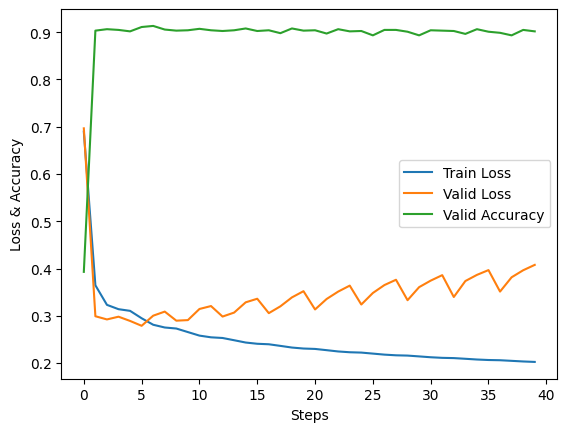

In [14]:
# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()

从运行结果可以看出，随着训练周期的增加，训练数据和校验数据的损失函数曲线都在快速下降，在5-10个周期内，训练数据的损失函数就已经低于校验数据的损失函数了，更多的训练可能会导致神经网络产生一定程度的过拟合。

In [22]:
# 保存、提取模型（为展示用）
torch.save(model,'bow.mdl')
model = torch.load('bow.mdl')

通过下面的代码，可以看到模型在测试数据上的结果:

In [23]:
#在测试集上分批运行，并计算总的正确率
vals = [] #记录准确率所用列表

#对测试数据集进行循环
for data, target in zip(test_data, test_label):
    data, target = torch.tensor(data, dtype = torch.float).view(1,-1), torch.tensor(np.array([target]), dtype = torch.long)
    output = model(data) #将特征数据喂入网络，得到分类的输出
    val = rightness(output, target) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].data.numpy() / rights[1]
right_rate

0.8994627782041443

计算输出的分类准确率达到90%。至此我们训练好了一个分类神经网络，可以比较准确地识别京东商品评论所含情绪。

当然，这仅能说明我们的神经网络针对网上购物评论效果很好，它不一定能判断出一般的自然语言中的情绪。这是因为神经网络的工作严重依赖于训练数据。如果换一组不同风格的新数据，它的准确率就会有所下降。

### 3.5 剖析神经网络

尽管模型在测试集上的分类准确率已经高达90%，但还是有少数样本分类错误，我们可以剖析这个训练好的神经网络。

首先，通过下列代码查看模型有哪些参数：

In [24]:
#打印出神经网路的架构，方便后续访问
model.named_parameters

<bound method Module.named_parameters of Sequential(
  (0): Linear(in_features=7135, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=2, bias=True)
  (3): LogSoftmax(dim=1)
)>

可以看到，神经网络歌词各层的计算单元。这里的层与神经网络的神经元层并不一致。这里返回的是计算图上的各个计算节点，它将每一个神经元层拆成了线性运算（Linear）和非线性运算（例如ReLU和LogSoftmax）两部分。

在各个运算前面都有一个数字，我们可以用这些数字i和语句model[i]来访问训练好的神经网络权重值。

将隐含层节点到输出层节点的各个权重显示出来：

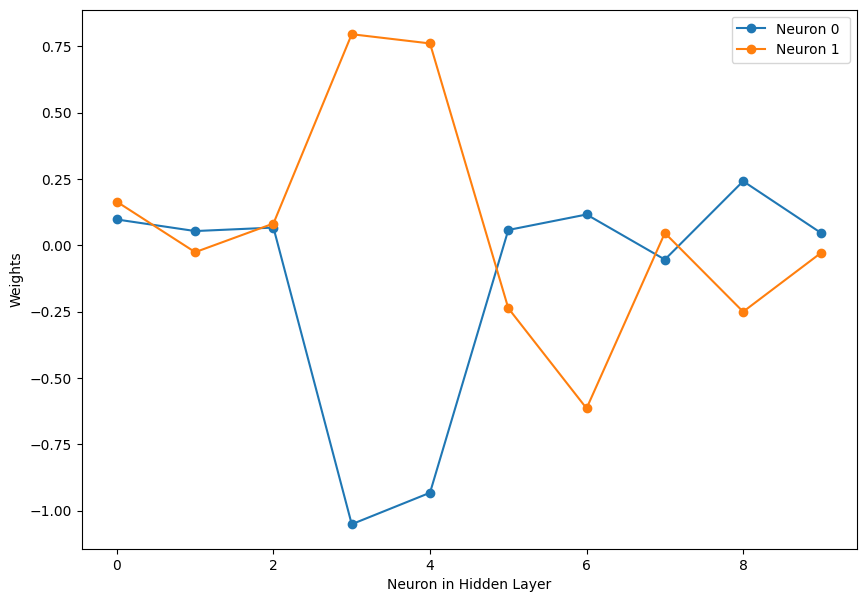

In [68]:
# 绘制第二个全连接层的权重大小
# model[2]即提取第2层
# 网络一共有4层，第0层为线性神经元，第1层为ReLU，第2层为第二层神经元连接，第3层为LogSoftmax
plt.figure(figsize=(10, 7))

# 获取第二层权重
weights_matrix = model[2].weight.data.numpy()

# 循环遍历权重
for i in range(weights_matrix.shape[0]):
    weights = weights_matrix[i, :]
    plt.plot(range(weights.shape[0]), weights, 'o-', label=f'Neuron {i} ')

plt.legend()
plt.xlabel('Neuron in Hidden Layer')
plt.ylabel('Weights')
plt.show()

图中横坐标为隐含层10个单元的编号，纵坐标为神经网络训练好的权重值，两条曲线分别对应第1个和第2个输出神经元。可以看到，这两条曲线呈现出相反的波动模式，这说明两类是互补的。不部分神经元的权重值是非常大的，比较重要。

我们采用的词袋模型的特点是每一个输入神经元对应一个单元，因此我们希望将每一个隐含神经元所对应的最大权重和最小权重（有可能是负值）所对应的单词打印出来。

In [35]:
# 对于第二层各个神经元与输入层的连接权重，挑出最大权重和最小权重，考察并打印每一个权重所对应的单词
# model[0]是取出第一层的神经元

for i in range(len(model[0].weight)):
    print('\n')
    print('第{}个神经元'.format(i))
    print('max:')
    st = sorted([(w,i) for i,w in enumerate(model[0].weight[i].data.numpy())])
    for i in range(1, 20): #循环从排序后的列表中选择最大（正权重）和最小（负权重）的20个权重。
        word = index2word(st[-i][1],diction)
        print(word)
    print('min:')
    for i in range(20):
        word = index2word(st[i][1],diction)
        print(word)



第0个神经元
max:
寄送
之类
惨不忍睹
考虑
真服了
牺牲
快成
200
42
评鞋
残次品
成份
十块钱
佩服
灰蓝
皮料
一灰一
戈壁
往里
min:
了
洗
全都
下次
这
买
衣服
在
最差
质量
款
的
绒
只
成堆
一二次
不
示东
再也
铺就


第1个神经元
max:
我要
挺轻
贵
考虑一下
做事
穿穿看
要用
13
比前
误差
棉裤
非你莫属
纳闷
谱
分不多
果然
够
邻居们
谓
min:
还好
无
哇
细看
三十岁
当作
邮出
要换
打开
质感
wo
右肩
擦亮
过边
厚实
天气
之前
发图
胶底
3X


第2个神经元
max:
偏小穿
廉价
大哥
保暖
体型
无良
火大
利用
忘怀
不知去向
钱
当时
至少
号码
月
材料
破碎
太贵
阿
min:
了
在
成堆
洗
衣服
示东
再也
最差
绒
这
不
质量
的
一二次
下次
全都
款
买
只
乱放


第3个神经元
max:
地摊货
退
玩意
差劲
严重
退款
最差
丢
发错
鬼
很差
找
一股
差差
难看
却
办法
伤心
不如
min:
广西南宁
没得说
还会来
谢谢
继续
完全一致
很软
惊喜
色彩
抱
物超所值
却是
超值
正合适
太好
棒
吸引
码短
来说
物有所值


第4个神经元
max:
地摊货
退
玩意
严重
差劲
退款
最差
丢
鬼
发错
很差
难看
破
差差
差评
却
不如
伤心
办法
min:
没得说
继续
力
惊喜
抱
可
宝贝
外观
物有所值
超值
完全一致
谢谢
来说
耐心
却是
稍微
价格
挺不错
划算
还会来


第5个神经元
max:
棉
无效
穿点
头版
好大
款项
京东
真服了
球
拉机
没早
jd
说出
时买
值
一洗
贪图便宜
长安
爽
min:
下次
买
款
只
再也
不
示东
了
在
一二次
质量
最差
这
洗
的
衣服
全都
成堆
绒
中下部


第6个神经元
max:
耐心
划算
掌柜的
还来
nbsp
亲身经历
我用
YY
棒
及时
完全一致
努力
款
仔细
期望值
上档次
老朋友
quot
放心
min:
垃圾
上当
差劲
月
单大
难看
醉
申请
千万
退
洞
烂
不敢恭维
很差
太差
烂货
没货
一星
假货
差评


第7个神经元
max:
付费
还错
人暖心
正赞
乱缝
货瞎起
太撇
80
傻
烂货
期望值
没差
人类

可以看到第三个神经元和第四个神经元起到了很大的作用 两个都对负面词赋予了很大的权重，而给正面词赋予了较小的权重，因此该神经元也在区分正面或负面的评价。

有了这些准备工作和认识之后，我们就可以把测试集中判断错误的句子挑选出来：

In [52]:
# 收集到在测试集中判断错误的句子
wrong_sentences = []
targets = []
j = 0
sent_indices = []
for data, target in zip(test_data, test_label):
    predictions = model(torch.tensor(data, dtype = torch.float).view(1,-1))
    pred = torch.max(predictions.data, 1)[1]
    target = torch.tensor(np.array([target]), dtype = torch.long).view_as(pred)
    rights = pred.eq(target)
    indices = np.where(rights.numpy() == 0)[0]
    for i in indices:
        wrong_sentences.append(data)
        targets.append(target[i])
        sent_indices.append(test_size + j + i)
    j += len(target)

这样，判断错误的句子就全部被存到了sent_indices中，可以使用下面代码：

In [56]:
# 逐个查看出错的句子是什么
idx = 9
print(sent_indices)
print(sentences[sent_indices[idx]])
print(targets[idx].numpy())
lst = list(np.where(wrong_sentences[idx]>0)[0])
mm = list(map(lambda x:index2word(x, diction), lst))
print(mm)

[1313, 1324, 1336, 1342, 1356, 1375, 1391, 1395, 1396, 1400, 1409, 1416, 1445, 1447, 1455, 1463, 1465, 1484, 1486, 1494, 1507, 1528, 1552, 1556, 1561, 1563, 1564, 1566, 1579, 1595, 1601, 1604, 1614, 1617, 1637, 1638, 1646, 1660, 1661, 1666, 1703, 1725, 1728, 1742, 1756, 1786, 1817, 1822, 1823, 1831, 1834, 1855, 1865, 1881, 1895, 1897, 1912, 1923, 1931, 1941, 1945, 1975, 1977, 1990, 1996, 2003, 2005, 2012, 2018, 2028, 2031, 2032, 2034, 2043, 2053, 2083, 2096, 2105, 2124, 2140, 2171, 2180, 2182, 2184, 2196, 2220, 2224, 2231, 2233, 2237, 2241, 2253, 2257, 2260, 2294, 2299, 2300, 2313, 2317, 2319, 2346, 2348, 2362, 2363, 2367, 2376, 2389, 2395, 2414, 2421, 2425, 2452, 2463, 2465, 2473, 2476, 2485, 2490, 2492, 2501, 2519, 2528, 2529, 2550, 2553, 2554, 2564, 2565, 2567, 2568, 2597]
['你', '大爷', '的', '穿', '了', '几次', '就', '爆皮', '了', '什么', '垃圾', '货', '搞', '到', '京东', '来', '卖', '祝', '你', '全家', '不得好死']
0
['的', '就', '了', '穿', '到', '卖', '你', '来', '祝', '货', '什么', '几次', '京东', '搞', '大爷', '爆皮', '垃圾', '全家

我们只需要变换上述代码中的idx数值，就可以打印输出不同句子的所有词及其对应的标签。

In [71]:
# 观察第一层的权重与输入向量的内积结果，也就是对隐含神经元的输入
# 最大数值对应的项就是被激活的神经元，负值最小的神经元就是被抑制的神经元
model[0].weight.data.numpy().dot(wrong_sentences[idx].reshape(-1, 1))

array([[-9.76654450e-03],
       [-1.24465322e-03],
       [-1.15373080e-02],
       [ 6.00505116e+00],
       [ 4.63275365e+00],
       [-7.88265584e-03],
       [ 9.95034856e+00],
       [-2.16705352e-03],
       [-1.79781790e-02],
       [-7.11921441e-02]])

In [72]:
# 显示输入句子的非零项，即对应单词不为空的项，看它们到隐含层指定神经元的权重是多少
model[0].weight[0].data.numpy()[np.where(wrong_sentences[idx]>0)[0]]

array([-0.05433807,  0.00414848, -0.07124317,  0.00108936, -0.00620088,
        0.00298505, -0.0086809 ,  0.00135333, -0.00123214, -0.00443722,
        0.00505405,  0.01142853, -0.00034485, -0.00866331,  0.00820292,
        0.00107504,  0.0022407 , -0.00356469, -0.00404559], dtype=float32)

由此可见，第6个神经元的数值最大，而我们通过之前的分析也已经知道，第6个神经元基本就是在监测正面的词，所以，该输入数据应能被归类为好评。所以，程序符合我们的判断.

采用这样的方法对大量分类错误的句子进行了分析，总结了几种出错的原因。

<div style="text-align:center">
    <img src="pic5.jpg" alt=校验集类" width="800" style="display:inline-block">
</div>


由此看来，我们的词袋模型出错可能包含多种原因，必须要具体问题具体分析，其中最后一种原因是词袋模型的致命弱点。词袋模型由于打乱了输入词之间的前后顺序，因此无法理解句子中前后相关的词语。